**This notebook contains followings:**
* Data Merging
* Deep Surv


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sksurv.svm import FastSurvivalSVM
from pycox.datasets import metabric

In [75]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [76]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [77]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [78]:
#Standardizing cols

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

print (standardize)

x_mapper = DataFrameMapper(standardize + leave)


[(['x0'], StandardScaler()), (['x1'], StandardScaler()), (['x2'], StandardScaler()), (['x3'], StandardScaler()), (['x8'], StandardScaler())]


In [79]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [80]:
print (x_train)

[[-0.6789899   1.5512409   0.01523471 ...  1.          0.
   1.        ]
 [-1.0300117   3.2727063  -0.41635963 ...  0.          0.
   1.        ]
 [ 0.4767839  -0.85106283 -1.5497689  ...  0.          0.
   0.        ]
 ...
 [-0.3512742  -0.9187757   2.4904273  ...  0.          0.
   1.        ]
 [ 0.65737414 -0.8210056   0.63686645 ...  0.          0.
   1.        ]
 [-0.5448622  -0.7461271  -0.79741466 ...  1.          0.
   0.        ]]


In [81]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)

val = x_val, y_val
#val= df_b = pd.DataFrame(columns=['duration', 'event'])
print (y_train)


(array([ 99.333336,  95.73333 , 239.3     , ...,  37.866665, 198.43333 ,
       140.76666 ], dtype=float32), array([0, 1, 0, ..., 1, 0, 0]))


In [12]:
print (y_train)

(array([ 99.333336,  95.73333 , 239.3     , ...,  37.866665, 198.43333 ,
       140.76666 ], dtype=float32), array([0, 1, 0, ..., 1, 0, 0]))


# Deep surv model

In [88]:
in_features = x_train.shape[1]
num_nodes = [128, 128]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

print (x_train.shape)
#x_train = torch.from_numpy(x_train)
#x_train= torch.reshape(x_train,(256, 1, len(x_train)))
# x_train = x_train[:,:,None]
# print (x_train.shape)

(1218, 9)


In [83]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lin_first = torch.nn.Linear(in_features, 32)
        self.conv_7= torch.nn.Conv1d(in_channels= 256, out_channels= 32, kernel_size= 7, padding= 'same')
        self.max_pool= torch.nn.MaxPool1d (kernel_size=3, stride=1, padding=1)
        self.avg_pool= torch.nn.AdaptiveAvgPool1d(32)    
        self.conv_3= torch.nn.Conv1d(in_channels= 32, out_channels= 32, kernel_size= 3, padding= 'same')
        self.lin = torch.nn.Linear(32, 32)
        self.lin_out = torch.nn.Linear(32, out_features)
        self.batchn= torch.nn.BatchNorm1d(9)
        self.drop= torch.nn.Dropout(0.1)
        self.relu = torch.nn.ReLU()

    def forward(self, x_tensor):
        print (x_tensor.shape)
        # x= self.lin_first(x_tensor)
        # x= self.relu (x)
        # x= self.batchn (x)
        # x= self.drop(x)
        x= self.conv_7(x_tensor)
        x= self.batchn(x)
        x= self.max_pool(x)
        x_add= self.drop(x)

        x= self.conv_3(x_add)
        x= self.batchn(x)
        x= self.relu(x)
        x= self.conv_3(x)
        x= self.batchn(x)

        x= x_add + x
        x= self.relu(x)


        x= self.avg_pool(x)
        return self.lin_out(x)

    def predict(self, x_tensor):
        x = self.forward(x_tensor)
        return x
net = Net()

In [89]:
model = CoxPH(net, tt.optim.Adam)

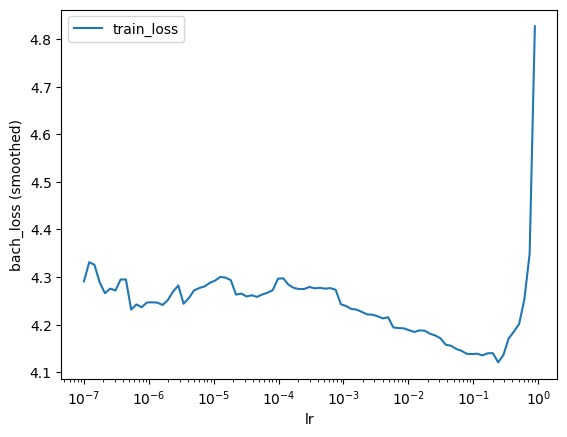

In [90]:
batch_size = 128
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [91]:
lrfinder.get_best_lr()

0.02420128264794396

In [92]:
model.optimizer.set_lr(0.001)

In [93]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [94]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.1384,	val_loss: 3.7728
1:	[0s / 0s],		train_loss: 4.0339,	val_loss: 3.7683
2:	[0s / 0s],		train_loss: 3.9902,	val_loss: 3.7843
3:	[0s / 0s],		train_loss: 3.9570,	val_loss: 3.7826
4:	[0s / 0s],		train_loss: 3.9486,	val_loss: 3.7797
5:	[0s / 0s],		train_loss: 3.9326,	val_loss: 3.7726
6:	[0s / 0s],		train_loss: 3.9351,	val_loss: 3.7690
7:	[0s / 0s],		train_loss: 3.9307,	val_loss: 3.7770
8:	[0s / 0s],		train_loss: 3.9199,	val_loss: 3.7772
9:	[0s / 0s],		train_loss: 3.9371,	val_loss: 3.7816
10:	[0s / 0s],		train_loss: 3.8951,	val_loss: 3.7851
11:	[0s / 1s],		train_loss: 3.9070,	val_loss: 3.7842
CPU times: total: 531 ms
Wall time: 1.1 s


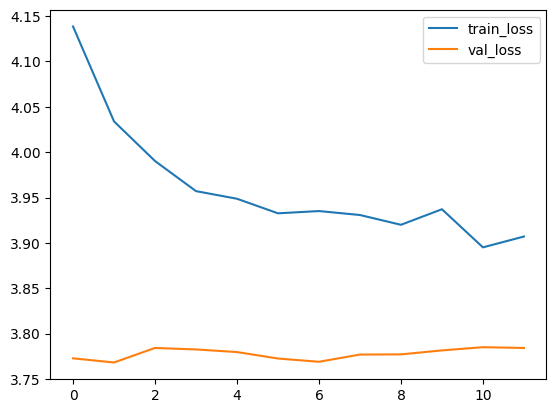

In [95]:
_ = log.plot()

In [96]:
model.partial_log_likelihood(*val).mean()

-4.973268

In [97]:
_ = model.compute_baseline_hazards()

In [98]:
surv = model.predict_surv_df(x_test)

In [99]:
print (surv)

                 0         1         2         3             4         5    \
duration                                                                     
0.100000    0.998960  0.999556  0.999424  0.999034  9.977609e-01  0.999627   
0.766667    0.998960  0.999556  0.999424  0.999034  9.977609e-01  0.999627   
1.233333    0.998960  0.999556  0.999424  0.999034  9.977609e-01  0.999627   
1.266667    0.998960  0.999556  0.999424  0.999034  9.977609e-01  0.999627   
1.433333    0.998960  0.999556  0.999424  0.999034  9.977609e-01  0.999627   
...              ...       ...       ...       ...           ...       ...   
335.600006  0.015672  0.169575  0.100011  0.021103  1.295440e-04  0.225281   
335.733337  0.009762  0.138545  0.076941  0.013598  4.673569e-05  0.190110   
337.033325  0.009762  0.138545  0.076941  0.013598  4.673569e-05  0.190110   
351.000000  0.004092  0.095580  0.047529  0.006066  7.183186e-06  0.139183   
355.200012  0.000736  0.045938  0.018369  0.001233  1.782951e-07

For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

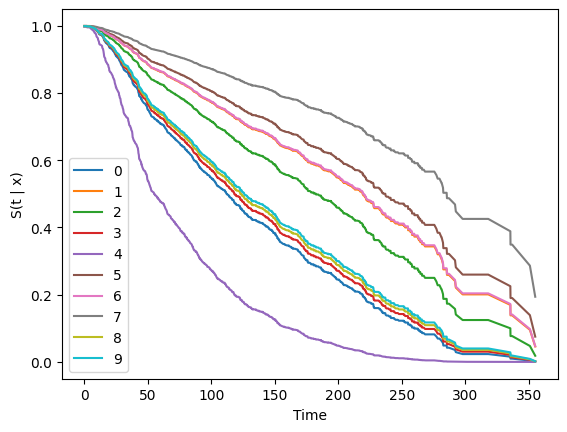

In [102]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. 
Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [197]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

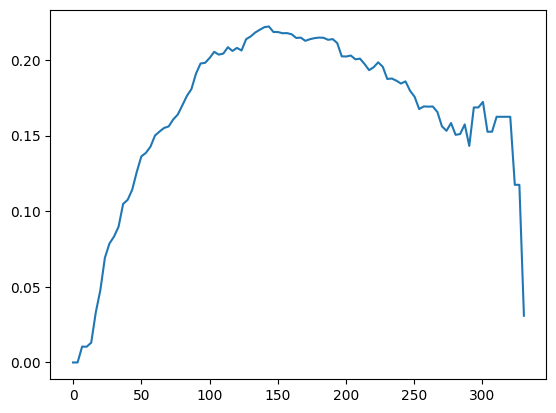

In [198]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [199]:
ev.integrated_brier_score(time_grid)

0.1661420360317745

In [200]:
ev.concordance_td()

0.6610442447872521

In [201]:
ev.integrated_nbll(time_grid)

0.5027428944048523

# Auton survival

In [1]:
import sys
sys.path.append('../')
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid
import pandas as pd


In [2]:
outcomes, features = datasets.load_support()

# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Let's take a look at the features
display(features.head(5))

# Let's take a look at the outcomes
display(outcomes.head(5))

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 5463
Number of validation data points: 1821
Number of test data points: 1821


In [4]:
param_grid = {'bs' : [5, 10],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [100], [100, 100] ]
             }

# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

In [5]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Data should be processed in a fold-independent manner when performing cross-validation. 
# For simplicity in this demo, we process the dataset in a non-independent manner.
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)

In [6]:
print (x)

           age    num.co    meanbp          wblc       hrt      resp  \
0     0.012772 -1.390013  0.449837 -6.931821e-01 -0.892283 -0.138967   
1    -0.148262  0.097711 -1.500702  5.187096e-01  0.470382  1.114591   
2    -0.635153  0.097711 -0.525432 -4.201759e-01 -0.290175  0.487812   
3    -1.299688  0.097711 -0.344827 -3.546971e-01 -0.290175  0.905665   
4     1.105258 -0.646151 -0.922764  1.258366e-01  0.470382 -0.347893   
...        ...       ...       ...           ...       ...       ...   
9100  0.219471 -0.646151  0.883291 -5.403626e-01  0.216863 -0.138967   
9101 -0.480786 -0.646151 -1.500702  1.939826e-16 -3.078884 -1.601451   
9102  0.495813 -0.646151  0.955533 -4.312668e-01 -0.448624  0.069960   
9103 -1.002436 -0.646151  0.522080 -5.185008e-01  0.407002  0.069960   
9104  1.211332 -0.646151 -0.344827 -4.092983e-01 -0.892283  0.069960   

          temp          pafi           alb          bili  ...  dzclass_Coma  \
0    -0.881504  1.569019e+00 -1.655686e+00 -5.238337e-01

In [138]:
from auton_survival.experiments import SurvivalRegressionCV

param_grid = {'k' : [4],
#              'distribution' : ['Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'layers' : [[100]]}

experiment = SurvivalRegressionCV(model='dcph', num_folds=4, hyperparam_grid=param_grid, random_seed=0)
times = np.quantile(outcomes.time[outcomes.event==1], [0.25, 0.5, 0.75]).tolist()
model = experiment.fit(x, outcomes, times, metric='brs')

At hyper-param {'k': 4, 'layers': [100], 'learning_rate': 0.0001}
At fold: 0


100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


At fold: 1


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


At fold: 2


100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


At fold: 3


100%|██████████| 50/50 [00:06<00:00,  7.30it/s]


At hyper-param {'k': 4, 'layers': [100], 'learning_rate': 0.001}
At fold: 0


100%|██████████| 50/50 [00:06<00:00,  7.77it/s]


At fold: 1


100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


At fold: 2


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


At fold: 3


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


In [140]:
print(experiment.folds)

[3 3 0 ... 0 0 0]


In [145]:
out_risk = model.predict_risk(x, times)
out_survival = model.predict_survival(x, times)

In [155]:
for fold in set(experiment.folds):
    print(survival_regression_metric('brs', outcomes[experiment.folds==fold], 
                                     out_survival[experiment.folds==fold], 
                                     times=times))

[0.1326722  0.19143411 0.19956605]
[0.12509491 0.18614828 0.20048262]
[0.12552882 0.18805158 0.20180174]
[0.12639552 0.18849708 0.20533201]


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man2\lib\site-packages\auton_survival\metrics.py:212: UserWarning: You are are evaluating model performance on the same data used to estimate the censoring distribution.
  warnings.warn("You are are evaluating model performance on the \
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man2\lib\site-packages\auton_survival\metrics.py:212: UserWarning: You are are evaluating model performance on the same data used to estimate the censoring distribution.
  warnings.warn("You are are evaluating model performance on the \
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man2\lib\site-packages\auton_survival\metrics.py:212: UserWarning: You are are evaluating model performance on the same data used to estimate the censoring distribution.
  warnings.warn("You are are evaluating model performance on the \
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man2\lib\site-package

In [150]:
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

def plot_performance_metrics(results, times):
  """Plot Brier Score, ROC-AUC, and time-dependent concordance index
  for survival model evaluation.
  Parameters
  -----------
  results : dict
      Python dict with key as the evaulation metric
  times : float or list
      A float or list of the times at which to compute
      the survival probability.
  Returns
  -----------
  matplotlib subplots
  """

  colors = ['blue', 'purple', 'orange', 'green']
  gs = gridspec.GridSpec(1, len(results), wspace=0.3)

  for fi, result in enumerate(results.keys()):
    val = results[result]
    x = [str(round(t, 1)) for t in times]
    ax = plt.subplot(gs[0, fi]) # row 0, col 0
    ax.set_xlabel('Time')
    ax.set_ylabel(result)
    ax.set_ylim(0, 1)
    ax.bar(x, val, color=colors[fi])
    plt.xticks(rotation=30)
  plt.show()

In [154]:
plot_performance_metrics(result, times)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [146]:
print (out_survival.shape)
df = pd.DataFrame(out_survival[0], columns = ['time'])

(9105, 3)


In [147]:
print (out_survival)

[[0.82047193 0.63404588 0.43281537]
 [0.67896032 0.41001534 0.19423884]
 [0.89807765 0.78072704 0.63447746]
 ...
 [0.87464408 0.73461405 0.56730962]
 [0.80207865 0.60179313 0.3932144 ]
 [0.87819642 0.74150238 0.57712522]]


KeyError: 'event'

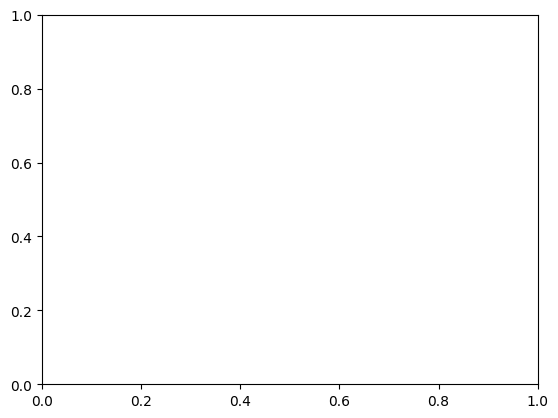

In [115]:
import auton_survival.reporting
auton_survival.reporting.plot_kaplanmeier(df)

In [69]:
# Define parameters for tuning the model
param_grid = {'bs' : [100, 200],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcph', random_seed=0, bs=param['bs'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    print (metric_val)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


0.1934094375180011


100%|██████████| 50/50 [00:05<00:00,  8.41it/s]


0.19714878456856283


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


0.19629104358336713


100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


0.2341954975043694


100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


0.1934094375180011


100%|██████████| 50/50 [00:05<00:00,  9.07it/s]


0.19714878456856283


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


0.19629104358336713


100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


0.2341954975043694


In [70]:
from auton_survival.metrics import survival_regression_metric
from auton_survival.metrics import _brier_score

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

metrics = ['brs', 'ibs', 'auc', 'ctd']
score = survival_regression_metric(metric= 'ctd', outcomes= y_te, predictions= predictions_te, times= times)

c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man2\lib\site-packages\auton_survival\metrics.py:212: UserWarning: You are are evaluating model performance on the same data used to estimate the censoring distribution.
  warnings.warn("You are are evaluating model performance on the \


In [71]:
print (score)

[0.7633611651636759, 0.748045486851457, 0.7171625588383443, 0.7015316473258344, 0.6856183652719376, 0.6842822807812068, 0.6798222761560285, 0.6764180262988347, 0.6733622229105641, 0.6692406887565787]


In [72]:
out_survival = model.predict_survival(x_tr, times)
print (out_survival)

[[0.97122913 0.94851727 0.91986141 ... 0.71999322 0.65741351 0.51166923]
 [0.92739276 0.87242707 0.805988   ... 0.4281653  0.33856803 0.17725112]
 [0.93514644 0.8856782  0.82542031 ... 0.4702212  0.38159212 0.21457883]
 ...
 [0.95161027 0.91411125 0.86768697 ... 0.57226332 0.49034456 0.3203041 ]
 [0.92645573 0.87083174 0.80365999 ... 0.42332216 0.33368603 0.17318561]
 [0.96051489 0.92965694 0.89112239 ... 0.6354991  0.56055667 0.39665121]]


<Axes: xlabel='timeline'>

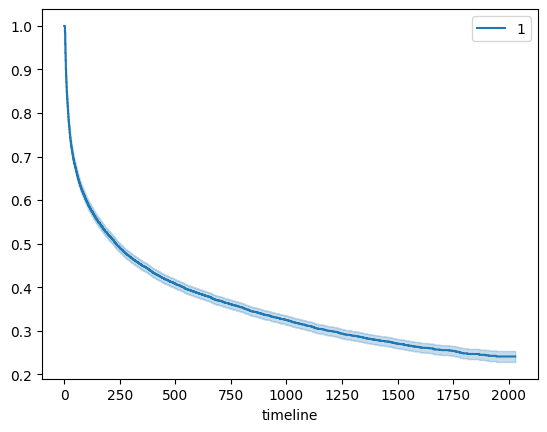

In [32]:
import auton_survival.reporting
auton_survival.reporting.plot_kaplanmeier(outcomes)